# Clustering

In [16]:
# Import KMeans from sklearn.cluster
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

sb.set_theme()

# import data frames
%store -r final_data
# simplified dataframe with Principal components
%store -r data6D

In [17]:
print(data6D)

     gdp-health-demographics-inv  trade-inv  agri-pop  weak-gdp-inv  \
0                       3.473448  -0.537316  0.074081     -0.235088   
1                      -0.202452   1.186812  0.610414      1.070507   
2                       0.204608   0.443911 -0.728013      1.330052   
3                      -2.043319   0.576546  0.344473     -0.951513   
4                       3.554933  -1.534343 -1.964757      0.905562   
..                           ...        ...       ...           ...   
186                    -0.534308   0.481981 -0.309286     -0.042963   
187                     0.278156  -0.374078  0.043061      1.390105   
188                     2.703719  -0.262932  0.197439     -0.432571   
189                     3.099094  -1.207925 -1.517319      0.408814   
190                     2.432728  -0.365457  0.018818     -0.519973   

     education-inv  labour-participation-inv  \
0         0.511475                 -1.941004   
1        -0.234381                 -0.595684   
2  

# Determining ideal number of clusters
We will be trying two methods to determine the ideal number of clusters:  
1. Elbow method based on WSS  
2. Silhouette method  


### Elbow method
Varry clusters from 1 to 50

C:\Users\guoch\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<AxesSubplot:xlabel='clusters', ylabel='wss'>

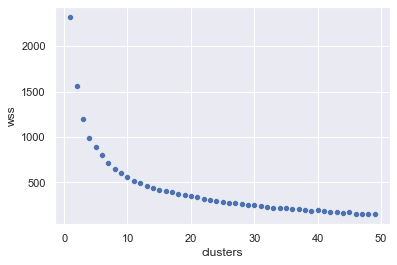

In [18]:
CLUSTERS = range(1,50) # clusters
CENTROID_SEL = "k-means++"

# exlcude countries
countries = data6D["Country"]
data6D = data6D.drop(columns=["Country"])

# array to store: (cluster_num, score)
scores = []

# generate WSS score for each cluster_num from 1 to 50
for num in CLUSTERS:
    kmeans = KMeans(n_clusters=num, init=CENTROID_SEL)
    model = kmeans.fit(data6D)
    wss = model.inertia_
    scores.append([num, wss])

# convert array to dataframe
scores = pd.DataFrame(scores, columns=["clusters", "wss"])

# plot the scores on "eblow plot"
sb.scatterplot(x="clusters", y="wss", data=scores)

From elbow method plot, the ideal number of clusters appears to be between 4 to 6

### Silouhette method

Silhouette score can be within a range of -1 to +1. The higher the score the better.  

score measures both cohesion (inter cluster closeness) and seperation (between cluster seperation).   

Each data point (x) has a value for cohesion and seperation. 
cohesion, a = mean of euclidean distance from x to every other point within the cluster  
seperation = mean of euclidean distance from x to every point in another cluster  
b = minimum of all the seperation scores (this gives us the average distance to the nearest cluster)  
silouhette coefficient = (b - a) / max(a,b)  
Since we want b to be as large as possible and a to be as small as possible: the best score is 1 and worst is -1  

Cluster with highest score:
   clusters     score
2         4  0.338396


<AxesSubplot:xlabel='clusters', ylabel='score'>

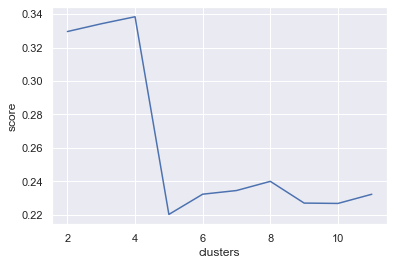

In [19]:
scores = []
CLUSTERS = CLUSTERS = range(2,12) # minimum of 2 clusters in needed to calculate silouhette score
for num in CLUSTERS:
    # labels is an array, where each  data-point is assigned to a cluster
    # example: [0,1,1,2,4,3,...] means that the first point is in cluster 0, 2nd point is in cluster 1 and so on
    labels = KMeans(n_clusters=num, init=CENTROID_SEL, random_state=200).fit(data6D).labels_

    # determine silouhette score
    score = metrics.silhouette_score(data6D, labels, metric="euclidean")
    scores.append([num, score])

# convert array to dataframe
scores = pd.DataFrame(scores, columns=["clusters", "score"])

# select maximum score
max = scores["score"].max()
print("Cluster with highest score:")
print(scores[scores["score"] == max])

# plot the scores on "eblow plot"
sb.lineplot(x="clusters", y="score", data=scores)


We will use 4 as our number of clusters according to the result from the silhouette score analysis 

# Creating and Evaluating KMeans model

In [20]:
OPTIMAL_CLUSTERS = 4
model = KMeans(n_clusters = OPTIMAL_CLUSTERS, init = CENTROID_SEL, n_init = 100).fit(data6D)


Within Cluster Sum of Squares : 988.923841343552



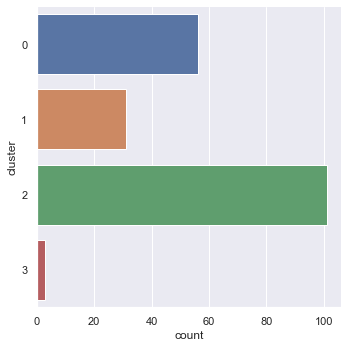

In [21]:
# Print the Within Cluster Sum of Squares
print("Within Cluster Sum of Squares :", model.inertia_)
print()

# Predict the Cluster Labels
cluster_labels = model.predict(data6D)

# add cluster labels back to data
clustered_data = data6D.copy()
clustered_data["cluster"] = pd.Categorical(cluster_labels)

# Summary of the Clusters
sb.catplot(y = "cluster", data = clustered_data, kind = "count")

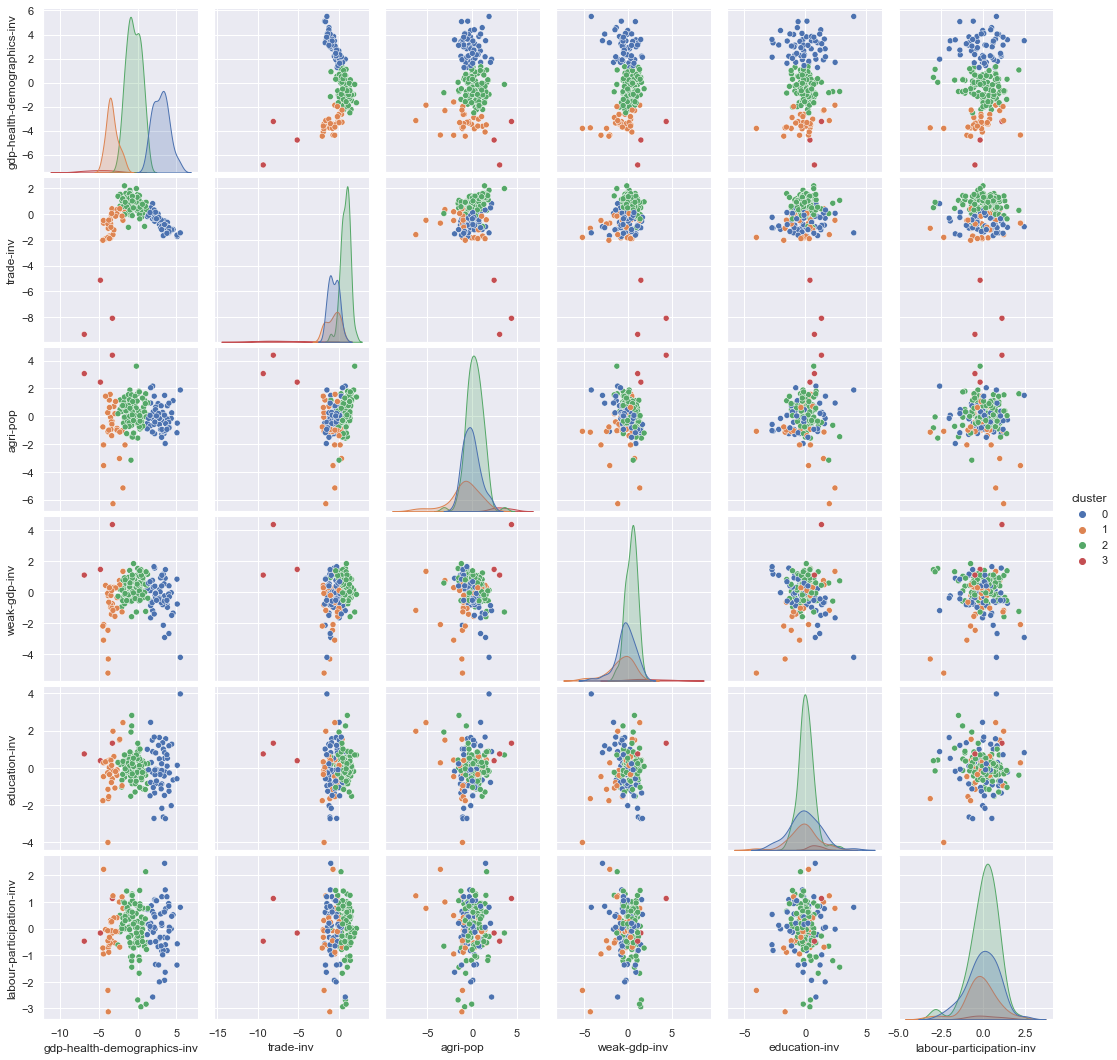

In [22]:
# Plot the Clusters on 2D grids
sb.pairplot(clustered_data, vars = data6D.columns.values, hue = "cluster")

In [23]:
clustered_data["Country"] = countries

In [24]:
# countries in cluster 0
cluster0 = clustered_data[clustered_data["cluster"] == 0]["Country"]
cluster1 = clustered_data[clustered_data["cluster"] == 1]["Country"]
cluster2 = clustered_data[clustered_data["cluster"] == 2]["Country"]
cluster3 = clustered_data[clustered_data["cluster"] == 3]["Country"]


In [25]:
clustered_data.head()

,gdp-health-demographics-inv,trade-inv,agri-pop,weak-gdp-inv,education-inv,labour-participation-inv,cluster,Country
0,3.473448,-0.537316,0.074081,-0.235088,0.511475,-1.941004,0,Afghanistan
1,-0.202452,1.186812,0.610414,1.070507,-0.234381,-0.595684,2,Albania
2,0.204608,0.443911,-0.728013,1.330052,1.061151,-1.678352,2,Algeria
3,-2.043319,0.576546,0.344473,-0.951513,-1.026634,0.069516,2,Andorra
4,3.554933,-1.534343,-1.964757,0.905562,-0.178777,-1.640465,0,Angola


In [26]:
print("Cluster 0")
print(cluster0)

Cluster 0
0                           Afghanistan
4                                Angola
18                                Benin
20     Bolivia (Plurinational State of)
26                         Burkina Faso
27                              Burundi
29                             Cambodia
30                             Cameroon
32             Central African Republic
33                                 Chad
37                              Comoros
38                                Congo
45     Democratic Republic of the Congo
47                             Djibouti
53                    Equatorial Guinea
54                              Eritrea
56                             Ethiopia
61                               Gambia
64                                Ghana
68                               Guinea
70                                Haiti
85                                Kenya
86                             Kiribati
89     Lao People's Democratic Republic
92                            

In [27]:
print("Cluster 1")
print(cluster1)

Cluster 1
8                 Australia
9                   Austria
12                  Bahrain
16                  Belgium
24        Brunei Darussalam
31                   Canada
46                  Denmark
58                  Finland
59                   France
73                  Iceland
78                  Ireland
79                   Israel
80                    Italy
82                    Japan
87                   Kuwait
95            Liechtenstein
97               Luxembourg
109                  Monaco
118             Netherlands
119             New Zealand
123                  Norway
134                   Qatar
135       Republic of Korea
144              San Marino
146            Saudi Arabia
151               Singapore
158                   Spain
163                  Sweden
164             Switzerland
179    United Arab Emirates
180          United Kingdom
Name: Country, dtype: object


In [28]:
print("Cluster 2")
print(cluster2)

Cluster 2
1                                 Albania
2                                 Algeria
3                                 Andorra
5                     Antigua and Barbuda
6                               Argentina
                      ...                
176                                Tuvalu
178                               Ukraine
183                               Uruguay
186    Venezuela (Bolivarian Republic of)
187                              Viet Nam
Name: Country, Length: 101, dtype: object


In [29]:
print("Cluster 3")
print(cluster3)

Cluster 3
35                        China
63                      Germany
182    United States of America
Name: Country, dtype: object


<AxesSubplot:xlabel='labour-participation-inv', ylabel='cluster'>

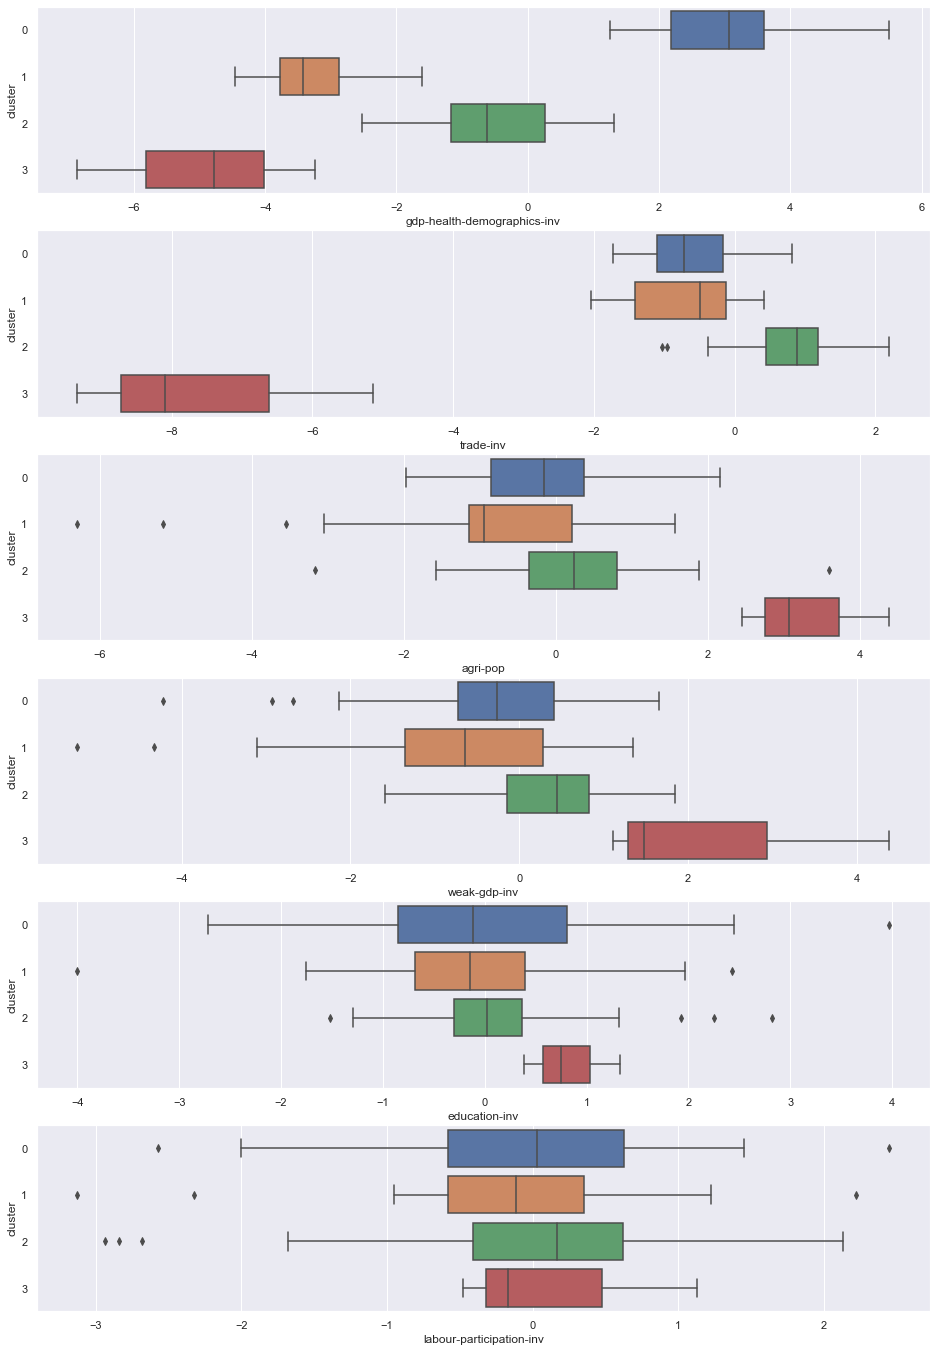

In [30]:
# Boxplots for all Features against the Clusters
f, axes = plt.subplots(6, 1, figsize=(16,24))
sb.boxplot(x = 'gdp-health-demographics-inv', y = 'cluster', data = clustered_data, ax = axes[0])
sb.boxplot(x = 'trade-inv', y = 'cluster', data = clustered_data, ax = axes[1])
sb.boxplot(x = 'agri-pop', y = 'cluster', data = clustered_data, ax = axes[2])
sb.boxplot(x = 'weak-gdp-inv', y = 'cluster', data = clustered_data, ax = axes[3])
sb.boxplot(x = 'education-inv', y = 'cluster', data = clustered_data, ax = axes[4])
sb.boxplot(x = 'labour-participation-inv', y = 'cluster', data = clustered_data, ax = axes[5])

<AxesSubplot:xlabel='cluster'>

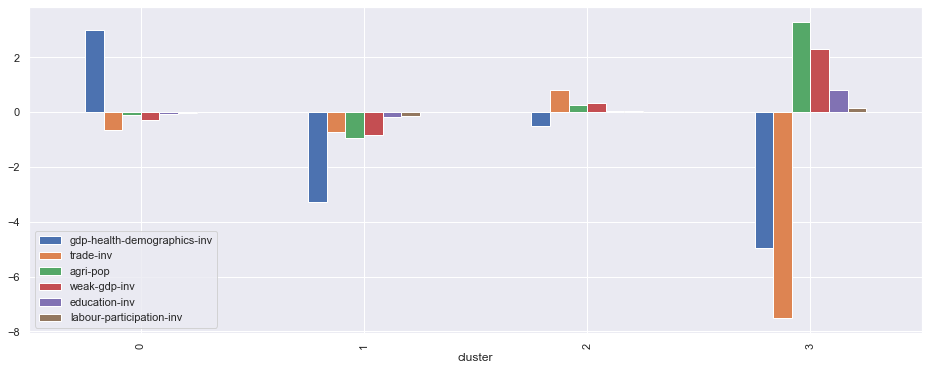

In [31]:
# Average Behaviour of each Cluster
grouped_data = pd.DataFrame(clustered_data.groupby(by = "cluster").mean())
grouped_data.plot.bar(figsize = (16,6))

### Insights
1. gdp-health-demographics-inv explains most of the variance between the countries  
2. Cluster 1 which contains the 3 "outliers" is likely due to the significantly negative trade balances the countries have.  
3. Cluster 3 which contains developed countries scored visibly lower on all indicators except for trade, where its distribution appears   similar to cluster 2.  
4. labour-participation-inv does not appear to be very useful in distinguishing clusters  
4. Cluster 2 scored highest for gdp-health-demographics-inv  

#### Summary
The least developed countries appear to be in cluster 0 and 2. We will explore these countries further.